In [46]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import f1_score
from gensim.models import FastText

In [55]:
def load_lex_data(dataset_name, feature_set):
    print("loading lex data for", dataset_name)
    dataset = pd.read_csv("../cleaned/" + dataset_name + "_clean.csv")
    
    targets = dataset["a"]
    #inputs = dataset[feature_set]
    inputs = dataset[["wc", "ewc", "hc", "ac", "fc"]]
    train_x, test_x, train_y, test_y = train_test_split(inputs, targets, test_size=0.2)
    return train_x, test_x, train_y, test_y    

def load_vector_data(dataset_name):
    print("loading vector data for", dataset_name)
    sentences = pd.read_csv("../cleaned/" + dataset_name + "_stems.csv", delimiter=",").astype(str).values.tolist()
    targets = pd.read_csv("../cleaned/" + dataset_name + "_clean.csv", delimiter=",").astype(str)["a"].tolist() 
    
    # replace placeholders (" "), make one-string-sentences
    print("... replacing placeholders")
    for index, sample in enumerate(sentences): 
            sentences[index] = list(filter((" ").__ne__, sample))
    inputs = [" ".join(sentence) for sentence in sentences]
    
    # build model over sentences (size=dimension of word vectors), convert sentences to vectors
    vector_model = FastText(size=32, window=3, min_count=1)
    vector_model.build_vocab(inputs)  
    vector_model.train(sentences=inputs, total_examples=len(inputs), total_words=vector_model.corpus_total_words, epochs=10)
    inputs = [vector_model.wv[sample] for sample in inputs]
    
    # split data and return
    train_x, test_x, train_y, test_y = train_test_split(inputs, targets, test_size=0.2)
    return train_x, test_x, train_y, test_y    

def classify_with_lr(train_x, test_x, train_y, test_y): 
    print("building lr model")
    lr = LogisticRegression(multi_class="multinomial", solver="newton-cg")
    print("... training model")
    lr.fit(train_x, train_y)
    print("... calcularing score")
    pred_y = lr.predict(test_x)
    # model metadata
    score, f1_scoore = lr.score(train_x, train_y), f1_score(test_y, pred_y, average="weighted")
    return (test_y, pred_y, score, f1_scoore), lr.coef_ 
    
def draw_confusion_matrix(dataset_name, feature_set_name, test_y, pred_y, score, f1_scoore): 
    fig = plt.figure()
    hm = sn.heatmap(confusion_matrix(test_y, pred_y), fmt="d", linewidth=0.5, annot=True, square=True, xticklabels=["h", "s", "a", "f"], yticklabels=["h", "s", "a", "f"], cmap="PuRd")
    ax1 = fig.add_axes(hm)
    ax1.set(xlabel="predicted", ylabel="target")
    desc = "dataset: {} ({})\nscore: {}, f1_score: {}".format(dataset_name, feature_set_name, score, f1_scoore)
    fig.text(0.5, -0.1, desc, ha='center')
    plt.show()
    print("saving", "cm_lr_" + dataset_name + "_" + feature_set_name + ".png")
    fig.savefig("../img/cm_lr_" + dataset_name + "_" + feature_set_name + ".png", bbox_inches="tight")

loading lex data for norm_emotion
building lr model
... training model
... calcularing score
loading lex data for norm_emotion
building lr model
... training model
... calcularing score
loading lex data for norm_emotion
building lr model
... training model
... calcularing score


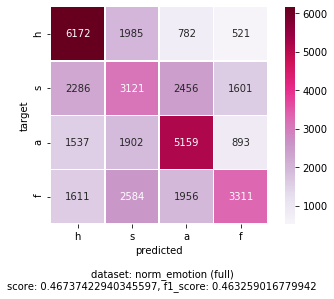

saving cm_lr_norm_emotion_full.png


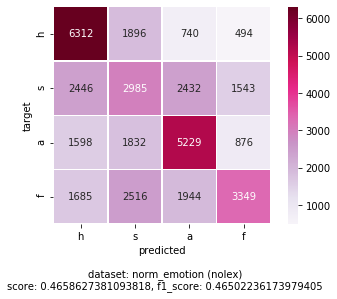

saving cm_lr_norm_emotion_nolex.png


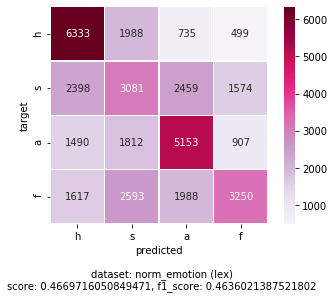

saving cm_lr_norm_emotion_lex.png


In [56]:
datasets = ["emotion", "norm_emotion", "tweet", "norm_tweet"]
features = {
    "full": ["wc", "uwc", "ewc", "cpc", "hc", "sc", "ac", "fc"],
    "nolex": ["wc", "uwc", "ewc", "cpc"],
    "lex": ["hc", "sc", "ac", "fc"]
}

norm_emotion_full = ["wc", "ewc", "hc", "ac", "fc"]

all_results = []
coefficients = []

for dataset in ["norm_emotion"]: 
    for key, feature_set in features.items(): 
        results, coef = classify_with_lr(*load_lex_data(dataset, feature_set))
        all_results.append([dataset, key, *results])
        coefficients.append(coef)
    #results, coef = classify_with_lr(*load_vector_data(dataset))
    #all_results.append([dataset, "vec", *results])
    #coefficients.append(coef)

for index, result in enumerate(all_results):
    draw_confusion_matrix(*result)
    #print(coefficients[index])

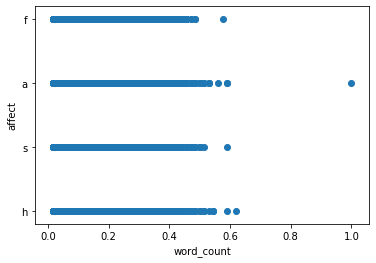

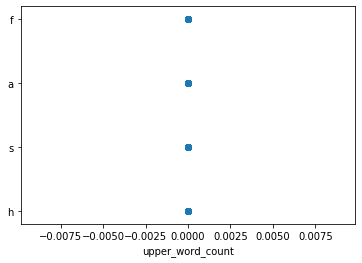

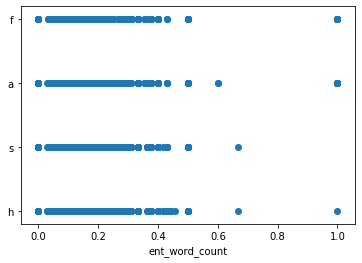

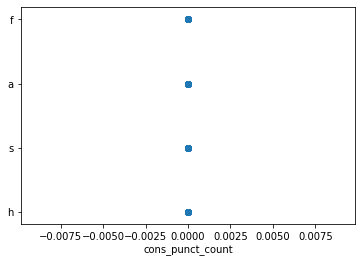

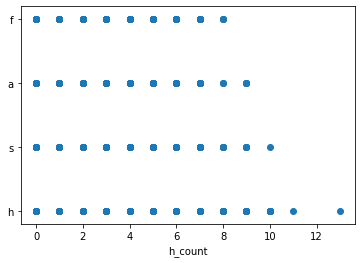

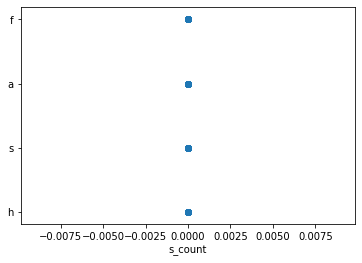

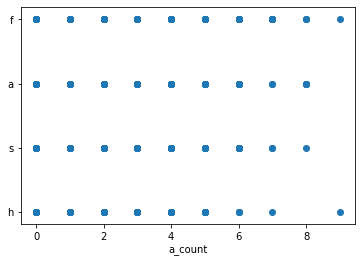

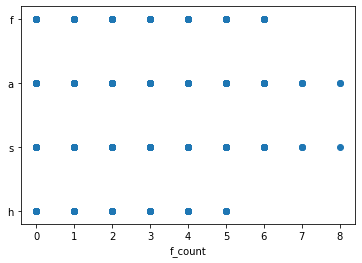